In [1]:
import os

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models

from tqdm import tqdm

In [2]:
try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Using Colab:", IN_COLAB)

Using Colab: False


# Segmentation Assignment

## TODO 0: Dataset Download

- Download the CCP dataset from https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset and save it to drive.
- You can use:
```bash
curl -L -o /content/drive/My\ Drive/clothing-coparsing-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/balraj98/clothing-coparsing-dataset
```
- Then, update this `datasetroot` link to point to the dataset.
- Update `projectroot` to point to where you want to store your outputs

In [3]:
if IN_COLAB:
    drive.mount('/content/drive')
    datasetroot = '/content/drive/My Drive/ccp/' # edit this 
    projectroot = '/content/drive/My Drive/ccp_root/' # edit this
else:
    datasetroot = "./clothing-coparsing-dataset/" # edit this
    projectroot = "./test_outputs" # edit this

In [4]:
def mask_rgb_to_labels(mask_rgb: torch.Tensor, df: pd.DataFrame, ignore_index: int = -1):
    """
    Convert an RGB segmentation mask tensor to:
    (1) class index tensor, and
    (2) one-hot encoded tensor.

    mask_rgb: torch.Tensor, shape (H, W, 3) or (3, H, W)
    df: pandas dataframe with columns ['r', 'g', 'b']
    ignore_index: index to assign to unknown colors

    Returns:
        index_tensor: (H, W) long tensor
        one_hot_tensor: (num_classes, H, W) float tensor
    """

    # --- Normalize mask shape to (H, W, 3) ---
    if mask_rgb.shape[0] == 3:  # (3, H, W) → (H, W, 3)
        mask_rgb = mask_rgb.permute(1, 2, 0)
    mask_rgb = mask_rgb.long()

    H, W, _ = mask_rgb.shape

    # --- Build mapping dict: (r,g,b) → index ---
    df = df.reset_index(drop=True)
    rgb_keys = (df["r"] * 256**2 + df["g"] * 256 + df["b"]).astype(int)
    rgb2idx = {int(k): int(i) for i, k in enumerate(rgb_keys)}

    # --- Compute key for each pixel ---
    keys = (
        mask_rgb[..., 0] * 256**2
        + mask_rgb[..., 1] * 256
        + mask_rgb[..., 2]
    )

    # --- Convert to indices with lookup ---
    # Build lookup table as tensor for speed
    # (max RGB key is < 256^3 = 16.7M)
    max_key = 256**3
    lut = torch.full((max_key,), ignore_index, dtype=torch.long)
    for k, idx in rgb2idx.items():
        lut[k] = idx

    index_tensor = lut[keys]

    # --- One-hot encode ---
    num_classes = len(df)
    one_hot = torch.nn.functional.one_hot(index_tensor.clamp(min=0), num_classes)
    one_hot = one_hot.permute(2, 0, 1).float()  # (H,W,C) → (C,H,W)

    return index_tensor, one_hot

In [5]:
class ClothesParsingDataset:
    def __init__(self, train=True, make_binary=False, bg_label=0):
        self.imagefolder = os.path.join(datasetroot,'images')
        self.maskfolder = os.path.join(datasetroot, 'labels', 'pixel_level_labels_colored')

        self.class_dict = os.path.join(datasetroot, "class_dict.csv")
        self.class_dict = pd.read_csv(self.class_dict)

        # train_set = range(1,1000,2)
        # val_set = range(2,1000,2)
        train_set = range(1,800)
        val_set = range(800, 1000)
        
        if train:
            self.idx = train_set
        else:
            self.idx = val_set

        ### We will resize the images to fixed size.
        # self.transform = transforms.Compose([transforms.Resize((384, 256)), transforms.ToTensor()])
        self.transform = transforms.Compose([
            transforms.Resize((384, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.masktransform = transforms.Resize((384,256), Image.NEAREST)
        self.numclasses = self.class_dict.shape[0]
        

        self.make_binary = make_binary
        if self.make_binary:
            self.numclasses = 2
        self.bg_label = bg_label


    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        if i>=self.__len__():
            raise IndexError
        i = self.idx[i]
        imgpath = os.path.join(self.imagefolder, '{:04d}.jpg'.format(i+1))
        maskpath = os.path.join(self.maskfolder, '{:04d}.png'.format(i+1))
        img = self.transform(Image.open(imgpath).convert('RGB'))
        mask, _ = mask_rgb_to_labels(torch.as_tensor(
            np.array(Image.open(maskpath)), dtype=torch.int64
        ), self.class_dict)
        mask = mask.unsqueeze(0)
        mask = self.masktransform(mask)
        mask = mask[0,:,:]
        if self.make_binary:
            mask[mask != self.bg_label] = 1
        return img, mask.long()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


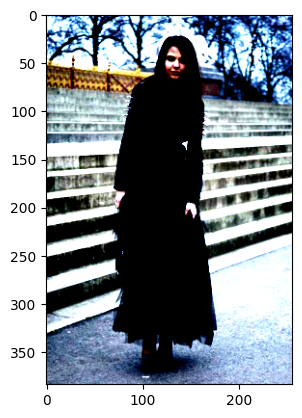

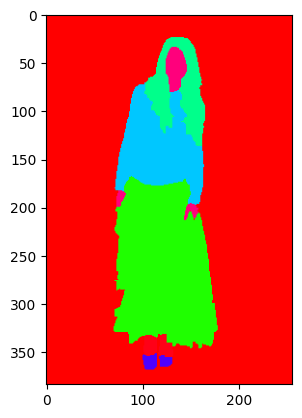

In [6]:
%matplotlib inline
# Visualize the images and masks
traindataset = ClothesParsingDataset(train=True)
img, mask = traindataset[0]
plt.figure(); plt.imshow(img.numpy().transpose(1,2,0))
plt.figure(); plt.imshow(mask.numpy(), cmap='hsv')
plt.show()

## TODO 1: ResNet Segmenter

- We will now implement a ResNet-based segmentation module.
- The goal is to define a module that, given a layer ID, extracts the feature map from the corresponding layer and then up-samples it to the original image dimension.
- Finally, we will run a 1-dimensional convolutional layer on the extracted feature map that outputs a distribution over the clothing classes.

1. **TODO 1(a)**: Populate this dictionary that maps ResNet15 blocks to the corresponding channel dimension amd the downsampling factor.
    - In the function below, define `resnet_layer_to_dims` and `resnet_layer_to_scale` where the keys are integers (each for layer, starting with 1), and the values are the values of channel dimensions and upsampling factors respectively.
    - Hint: Look at the source code for the ResNet15 class in pytorch torchvision, and look at `layer1`, `layer2`, `layer3`, etc.

In [7]:
def get_layer_configs():
    # YOUR CODE HERE
    resnet_layer_to_dims = {
        1: 64, 2: 128, 3: 256, 4: 512
    }
    resnet_layer_to_scale = {
        1: 4, 2: 8, 3: 16, 4: 32
    }
    return resnet_layer_to_dims, resnet_layer_to_scale

resnet_layer_to_dims, resnet_layer_to_scale = get_layer_configs()

2. **TODO 1(b)**: Create a CNN that uses featuremaps from the desired layerid of a pretrained ResNet18, and applies a single convolutional layer to produce a set of class scores per pixel. The output should be upsampled back to the size of the original image.

In [8]:
class CNNwithResnetFeatures(nn.Module):
    def __init__(self, numclasses, layerid):
        # YOUR CODE HERE
        super().__init__()
        self.layerid = layerid
        self.numclasses = numclasses
        self.base_model = models.resnet18(pretrained=True)
        in_channels = resnet_layer_to_dims[layerid]
        self.model = nn.Conv2d(in_channels, numclasses, kernel_size=1)

    def forward(self, x):
        # YOUR CODE HERE
        B, C, H, W = x.shape
        bm = self.base_model
        x = bm.conv1(x)
        x = bm.bn1(x)
        x = bm.relu(x)
        x = bm.maxpool(x)

        fm1 = bm.layer1(x)
        fm2 = bm.layer2(fm1)
        fm3 = bm.layer3(fm2)
        fm4 = bm.layer4(fm3)

        match self.layerid:
            case 1:
                feats = fm1
            case 2:
                feats = fm2
            case 3:
                feats = fm3
            case 4:
                feats = fm4
            case _:
                raise ValueError("Invalid layerid")
        
        res = self.model(feats)
        upsampled = F.interpolate(res, size=(H, W), mode='bilinear', align_corners=False)
        return upsampled

In [9]:
### BEGIN TESTS
model = CNNwithResnetFeatures(numclasses=100, layerid=3)
assert model(img[None]).shape == (1, 100, 384, 256)
model = CNNwithResnetFeatures(numclasses=100, layerid=2)
assert model(img[None]).shape == (1, 100, 384, 256)
model = CNNwithResnetFeatures(numclasses=100, layerid=1)
assert model(img[None]).shape == (1, 100, 384, 256)
### END TESTS

c:\Users\David Wang\OneDrive\Cornell\CS 5672 Frontiers of Computer Vision\cs5672cv-pa2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David Wang\OneDrive\Cornell\CS 5672 Frontiers of Computer Vision\cs5672cv-pa2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## TODO 2: Make GPUs go brrr... :) 

Write code to train the model. Use 20 epochs, and Adam as an optimizer with default hyperparameters

There are some extra parameters in this function that you can try to use for improving the performance of your model:

1. `use_weighted_loss`: Use a class-weighted loss for handling class imbalance
2. `class_wts`: Required if `use_weighted_loss==True`. Is a $C$-dimensional tensor where $C$ is the number of classes in your dataset.
3. `ignore_index`: See [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [10]:
def train(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=1e-6,
    weight_decay=0,
    save_path='/content/drive/My Drive/ccp_models/',
    use_weighted_loss=True,
    class_wts=None,
    ignore_index=-100,
):
    # YOUR CODE HERE
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if use_weighted_loss and class_wts is not None:
        class_wts = class_wts.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_wts, ignore_index=ignore_index)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model = model.to(device)

    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        curr_loss = 0.0
        for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            curr_loss += loss.item() * inputs.size(0)
        epoch_loss = curr_loss / len(train_loader.dataset)


        model.eval()
        curr_val_loss = 0.0
        with torch.no_grad():
            for inputs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                curr_val_loss += loss.item() * inputs.size(0)
        val_loss = curr_val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")
    
    if os.path.exists(os.path.join(save_path, 'best_model.pth')):
        model.load_state_dict(torch.load(os.path.join(save_path, 'best_model.pth')))

    return model

In [11]:
train_dset = ClothesParsingDataset(train=True)
val_dset = ClothesParsingDataset(train=False)
train_dataloader = DataLoader(train_dset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dset, batch_size=8, shuffle=False)

renet_features_3 = CNNwithResnetFeatures(train_dset.numclasses, 3)
renet_features_3 = renet_features_3.cuda()
outputdir = os.path.join(projectroot, 'checkpoints', "layer_3") # Replace with an appropriate path
final_model = train(renet_features_3, train_dataloader, val_dataloader, \
                    epochs=10, save_path = outputdir)


c:\Users\David Wang\OneDrive\Cornell\CS 5672 Frontiers of Computer Vision\cs5672cv-pa2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\David Wang\OneDrive\Cornell\CS 5672 Frontiers of Computer Vision\cs5672cv-pa2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Validation: 100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Epoch 1/10, Training Loss: 4.0577, Validation Loss: 4.0499
Best model saved with validation loss: 4.0499


Epoch 2/10 - Validation: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch 2/10, Training Loss: 4.0375, Validation Loss: 4.0284
Best model saved with validation loss: 4.0284


Epoch 3/10 - Validation: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Epoch 3/10, Training Loss: 4.0173, Validation Loss: 4.0068
Best model saved with validation loss: 4.0068


Epoch 4/10 - Validation: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Epoch 4/10, Training Loss: 3.9965, Validation Loss: 3.9852
Best model saved with validation loss: 3.9852


Epoch 5/10 - Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Epoch 5/10, Training Loss: 3.9756, Validation Loss: 3.9717
Best model saved with validation loss: 3.9717


Epoch 6/10 - Validation: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epoch 6/10, Training Loss: 3.9542, Validation Loss: 3.9440
Best model saved with validation loss: 3.9440


Epoch 7/10 - Validation: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Epoch 7/10, Training Loss: 3.9321, Validation Loss: 3.9278
Best model saved with validation loss: 3.9278


Epoch 8/10 - Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Epoch 8/10, Training Loss: 3.9096, Validation Loss: 3.9097
Best model saved with validation loss: 3.9097


Epoch 9/10 - Validation: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Epoch 9/10, Training Loss: 3.8862, Validation Loss: 3.8773
Best model saved with validation loss: 3.8773


Epoch 10/10 - Validation: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

Epoch 10/10, Training Loss: 3.8621, Validation Loss: 3.8609
Best model saved with validation loss: 3.8609


## TODO 3: Evaluate your model

**TODO 3(a)**: Write code to compute per-class accuracy given a vector of predictions and labels.

In [ ]:
def compute_perclass_accuracy(predictions, labels):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
def eval_and_save_vis(model, dset, output_folder):
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    all_predicted = []
    all_true = []
    for i, (x, y) in enumerate(tqdm(dset)):
        x = x.unsqueeze(0)
        x = x.cuda()
        scores = model(x)
        shape = scores.shape[2:]
        scores = scores.reshape((scores.shape[1], -1))
        predicted = torch.argmax(scores, dim=0).cpu().numpy()
        all_predicted.append(predicted)
        all_true.append(y.numpy().reshape(-1))
        predicted_map = predicted.reshape(shape)
        predicted_img = Image.fromarray(predicted_map.astype(np.uint8))
        predicted_img.save(os.path.join(output_folder, f'{i}.png'))
        truey = Image.fromarray(y.numpy().astype(np.uint8))
        truey.save(os.path.join(output_folder, f'{i}_gt.png'))
    return compute_perclass_accuracy(np.concatenate(all_predicted, axis=0), np.concatenate(all_true, axis=0))


In [ ]:
perclass_acc = eval_and_save_vis(
    final_model, 
    ClothesParsingDataset(train=False), os.path.join(projectroot, "outputs", "layer_3"))
print(np.nanmean(perclass_acc))

In [ ]:
assert np.nanmean(perclass_acc) >= 0.06

In [ ]:
valdataset = ClothesParsingDataset(train=False)
img, mask = valdataset[2]
predicted = Image.open(os.path.join(projectroot, "outputs", "layer_3", "2.png"))
gt = Image.open(os.path.join(projectroot, "outputs", "layer_3", "2_gt.png"))
plt.figure(); plt.imshow(predicted)
plt.figure(); plt.imshow(gt)

**TODO 3(b)**: Try the same experiment with Layer 4

In [ ]:
renet_features_4 = CNNwithResnetFeatures(100, 4)
train_dataloader = DataLoader(ClothesParsingDataset(train=True), batch_size=8, shuffle=True)
val_dataloader = DataLoader(ClothesParsingDataset(train=False), batch_size=8, shuffle=False)
renet_features_4 = renet_features_4.cuda()
final_model = train(renet_features_4, train_dataloader, val_dataloader, epochs=10, 
                    save_path=os.path.join(projectroot, "checkpoints", "layer_4"))
perclass_acc = eval_and_save_vis(final_model, ClothesParsingDataset(train=False), os.path.join(projectroot, "outputs", "layer_4"))
print(np.nanmean(perclass_acc))

In [ ]:
### BEGIN TESTS
assert np.nanmean(perclass_acc) >= 0.07
### END TESTS

In [ ]:
valdataset = ClothesParsingDataset(train=False)
img, mask = valdataset[2]
predicted = Image.open(os.path.join(projectroot, "outputs", "layer_4", "1.png"))
gt = Image.open(os.path.join(projectroot, "outputs", "layer_4", "1_gt.png"))
plt.figure(); plt.imshow(predicted)
plt.figure(); plt.imshow(gt)
plt.show()

## TODO 4: This problem needs U(-Net)!

In this question, we will build a U-Net architecture.

1. Just as you did with ResNet 
2. Your network should upsample `layer4`, `layer3` and `layer2` to the dimensionality and scale of `layer1` using a `ConvTranspose2d`.
3. Then add the upsampled features to `layer1` and add a convolutional layer to produce the output.

In [ ]:
class UNetwithResnetFeatures(nn.Module):
    def __init__(self, numclasses):
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:

train_dset = ClothesParsingDataset(train=True)
val_dset = ClothesParsingDataset(train=False)

train_dataloader = DataLoader(train_dset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dset, batch_size=32, shuffle=False)
my_unet = UNetwithResnetFeatures(train_dset.numclasses)
my_unet = my_unet.cuda()
final_model = train(my_unet, train_dataloader, val_dataloader, epochs=10, lr=1e-3,
                    save_path=os.path.join(projectroot, "checkpoints", "unet"))



In [ ]:
perclass_acc_unet = eval_and_save_vis(final_model, ClothesParsingDataset(train=False), 
                                 os.path.join(projectroot, "outputs", "unet"))


In [ ]:
valdataset = ClothesParsingDataset(train=False)
img, mask = valdataset[1]
predicted = Image.open(os.path.join(projectroot, "outputs", "unet", "1.png"))
gt = Image.open(os.path.join(projectroot, "outputs", "unet", "1_gt.png"))
plt.figure(); plt.imshow(predicted)
plt.figure(); plt.imshow(gt)
plt.show()

### TODO 4(a): Report the performance of your U-Net

YOUR ANSWER HERE

### TODO 4(b): Try binary segmentation

Take the same U-Net model and try training it for binary segmentation

In [ ]:

train_dset = ClothesParsingDataset(train=True, make_binary=True)
val_dset = ClothesParsingDataset(train=False, make_binary=True)

train_dataloader = DataLoader(train_dset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dset, batch_size=32, shuffle=False)
mymodel = UNetwithResnetFeatures(train_dset.numclasses)
mymodel = mymodel.cuda()
final_model = train(mymodel, train_dataloader, val_dataloader, epochs=10, lr=1e-3,
                    save_path=os.path.join(projectroot, "checkpoints", "unet"), use_weighted_loss=True, class_wts=class_wts)


In [ ]:
perclass_acc_unet = eval_and_save_vis(final_model, ClothesParsingDataset(train=False), 
                                 os.path.join(projectroot, "outputs", "unet_binary"))

In [ ]:
print(np.nanmean(perclass_acc_unet), perclass_acc_unet)

In [ ]:
valdataset = ClothesParsingDataset(train=False)
img, mask = valdataset[1]
predicted = Image.open(os.path.join(projectroot, "outputs", "unet_binary", "1.png"))
gt = Image.open(os.path.join(projectroot, "outputs", "unet_binary", "1_gt.png"))
plt.figure(); plt.imshow(predicted)
plt.figure(); plt.imshow(gt)
plt.show()

### TODO 4(c): Some questions...

1. Did you observe a difference in the performance of your model on binary segmentation and multi-class segmentation? If yes, what was it?
2. Did you try any approaches to improve the performances of either of your models? If yes, tell us about them!
3. Did your model perform equally well on all classes in your multi-class segmentation model?
    1. If not, which classes did it perform better than others on? Can you explain why?

YOUR ANSWER HERE

# What to turn in?

Submit a zip file containing the following:

1. The final model checkpoints for your binary segmentation and multi-class segmentation model.
2. A `.py` file containing the class `UNetwithResnetFeatures` and the function `compute_perclass_accuracy`
3. An `.ipynb` file containing the completed notebook.